torch.uint8
torch.Size([50000, 3, 32, 32])
torch.uint8
torch.Size([50000, 3, 32, 32])
torch.uint8
torch.Size([1000, 3, 32, 32])
torch.uint8
torch.Size([1000, 3, 32, 32])


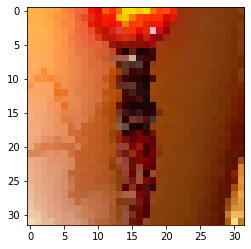

In [20]:
import torch
import matplotlib.pyplot as plt

train_dir = "train_data.pkl"
val_dir = "val_data.pkl"
noisy_imgs_1 , noisy_imgs_2 = torch.load("train_data.pkl")
noisy_imgs , clean_imgs = torch.load("val_data.pkl")

print(noisy_imgs_1.dtype)
print(noisy_imgs_1.shape)
print(noisy_imgs_2.dtype)
print(noisy_imgs_2.shape)
print(noisy_imgs.dtype)
print(noisy_imgs.shape)
print(clean_imgs.dtype)
print(clean_imgs.shape)

plt.imshow((noisy_imgs_1[1].float()/255.0).permute(1, 2, 0))

In [26]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'

In [21]:
from tqdm.notebook import tqdm #Make sure to only import from tqdm and not from tqdm.notebook when leaving the notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from unet import *

class NoisyDataset(Dataset):
    def __init__(self, X, Y):
        assert X.shape == Y.shape and X.ndim == 4
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
class Model():
    def __init__(self) -> None:
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = UNet(3, 3).to(self.device)
        
    def load_pretrained_model(self, filename="bestmodel") -> None:
        checkpoint = torch.load(filename+".pth", map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
    
    def save_trained_model(self, filename="bestmodel") -> None:
        torch.save({'model_state_dict': self.model.state_dict()}, filename+".pth")
        
    def predict(self, test_input) -> torch.Tensor:
        torch.cuda.empty_cache()
        self.model.eval()
        with torch.no_grad():
            out = self.model(test_input.to(self.device))
            return out
    
    def train_epoch(self, loader, optimizer, loss_fn) -> None:
        scaler = None if not torch.cuda.is_available() else torch.cuda.amp.GradScaler() #Speedup computation tricks. See https://pytorch.org/docs/stable/amp.html
        loop = tqdm(loader)

        for data, targets in loop:
            data = data.to(self.device)
            targets = targets.to(self.device)

            # forward
            if scaler is not None:
                with torch.cuda.amp.autocast(): #Speedup computation tricks. See https://pytorch.org/docs/stable/amp.html
                    predictions = self.model(data)
                    loss = loss_fn(predictions, targets)
            else:
                predictions = self.model(data)
                loss = loss_fn(predictions, targets)

            # backward
            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            loop.set_postfix(loss=loss.item())

    def train(self, train_input, train_target, num_epochs=10, batch_size=100, learning_rate=10e-4) -> None:
        torch.cuda.empty_cache()
        dataset = NoisyDataset(train_input, train_target)

        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.model.train()
        for epoch in tqdm(range(num_epochs)):
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            self.train_epoch(dataloader, optimizer, loss_fn)

In [22]:
def compute_psnr(denoised, target, max_range=1.0):
    assert denoised.shape == target.shape and denoised.ndim == 4
    return 20 * torch.log10(torch.tensor(max_range)) - 10 * torch.log10(((denoised-target) ** 2).mean((1,2,3))).mean()

def train_model(save_model=False, load_model=False):
    model = Model()

    train_input0, train_input1 = torch.load(train_dir)
    val_input, val_target = torch.load(val_dir)

    train_input0 = train_input0.float() / 255.0
    train_input1 = train_input1.float() / 255.0
    val_input = val_input.float() / 255.0
    val_target = val_target.float() / 255.0

    output_psnr_before = compute_psnr(val_input, val_target)

    if load_model:
        model.load_pretrained_model()
    else:
        model.train(train_input0, train_input1)
        if save_model:
            model.save_trained_model()

    mini_batch_size = 100
    model_outputs = []
    for b in tqdm(range(0, val_input.size(0), mini_batch_size)):
        output = model.predict(val_input.narrow(0, b, mini_batch_size))
        model_outputs.append(output.cpu())
    model_outputs = torch.cat(model_outputs, dim=0)

    output_psnr_after = compute_psnr(model_outputs, val_target)
    print(f"[PSNR : {output_psnr_after:.2f} dB], PSNR before training = {output_psnr_before:.2f} dB")
    return model_outputs

In [25]:
model_outputs = train_model(save_model=True, load_model=False)


[PSNR : 24.47 dB], PSNR before training = 20.72 dB


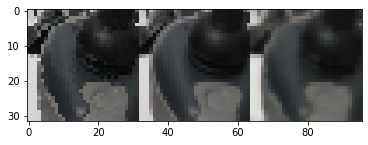

In [24]:
def plot_prediction_clean(img_noisy, img_clean, img_pred):
    assert img_noisy.ndim == img_clean.ndim == img_pred.ndim, "images should have same shape"
    if img_noisy.ndim == 4:
        assert img_noisy.shape[0] == img_clean.shape[0] == img_pred.shape[0] == 1, "can only plot for a single image"
        img_n = torch.squeeze(img_noisy).permute(1, 2, 0)
        img_c = torch.squeeze(img_clean).permute(1, 2, 0)
        img_p = torch.squeeze(img_pred).permute(1, 2, 0)
        img = torch.cat((img_n, img_c, img_p), dim=1)
        plt.imshow(img)
    else:
        assert img_noisy.ndim == 3, "image should be of the form nbChannels x height x width"
        img_n = img_noisy.permute(1, 2, 0)
        img_c = img_clean.permute(1, 2, 0)
        img_p = img_pred.permute(1, 2, 0)
        img = torch.cat((img_n, img_c, img_p), dim=1)
        plt.imshow(img)

i = 10
plot_prediction_clean(noisy_imgs[i].float()/255.0, clean_imgs[i].float()/255.0, model_outputs[i])